# Deep Learning for Human Vision Understanding 

## Basheer Alwaely and Ali Alsam

**Check tensorflow-GPU**

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**Check Cuda version**

In [3]:
!nvidia-smi

Mon Feb  1 16:03:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.89       Driver Version: 460.89       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   46C    P8     8W /  N/A |   5088MiB /  8192MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Import dependencies**

In [ ]:
import keras
from keras.preprocessing import image
from keras.engine import Layer
from keras.layers import Conv2D, Conv3D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from PIL import Image, ImageFile
from tensorflow.keras.models import load_model
import cv2
config = tf.compat.v1.ConfigProto()                               # you might not need this
config.gpu_options.allow_growth = True                            # you might not need this
session = tf.compat.v1.InteractiveSession(config=config)          # you might not need this

**Paramters**

You need to download datasets or collect images in the folder

In [5]:
IMG_SIZE = 256
length_test = 100

path_test = '/content/drive/MyDrive/Colorizing/Test-data'

datagen = ImageDataGenerator(rescale=1. / 255)
test = datagen.flow_from_directory(path_test, target_size=(IMG_SIZE, IMG_SIZE),batch_size=length_test,class_mode=None)

Found 100 images belonging to 1 classes.


**Blurred the blue channel**

Define measurement function

In [6]:
def data(Gamma):
    XX =[]
    YY =[]
    for img in test[0]:
        try:
            r, g, b = cv2.split(img)
            bb = cv2.GaussianBlur(b,(3*Gamma,3*Gamma),Gamma)
            blur = cv2.merge ( (r, g, bb) )
            XX.append(blur)
            YY.append(b)
        except:                
            print('error')
    XX = np.array(XX)
    YY = np.array(YY)
    return(XX,YY)

    
def MSE(img,org):
    return np.square(np.subtract(img,org)).mean()

def PSNR(img,org):
    return tf.image.psnr(img, org, max_val=1)    # cv2.PSNR(img, org)

def SSIM(img,org):
    return tf.image.ssim(img, org, max_val=1.0, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)

def static(output,YY):
    mse  = []
    psnr = []
    ssim = []
    for i in range(len(output)):
        img = output[i].reshape(IMG_SIZE,IMG_SIZE,-1)
        org = YY[i].reshape(IMG_SIZE,IMG_SIZE,-1)
        t1 = MSE(img,org)
        t2 = PSNR(img,org)
        t3 = SSIM(img,org)
        mse.append(t1)
        psnr.append(t2)
        ssim.append(t3)        
    mse = np.array(mse)
    psnr = np.array(psnr)
    ssim = np.array(ssim)
    return(mse,psnr,ssim)

**Import desired model and evaluation**

In [7]:
model = load_model('models/model_blue_35_DIV2K.h5')  
Gamma = 35
[XX,YY] = data(Gamma)
output = np.reshape(model.predict(XX), (-1, IMG_SIZE, IMG_SIZE))
[Mse,Psnr,Ssim] = static(output,YY)
print(np.sqrt(np.mean(Mse)))
print(np.mean(Psnr))
print(np.mean(Ssim))

0.08933992
22.404875
0.8457329


**Visual results**

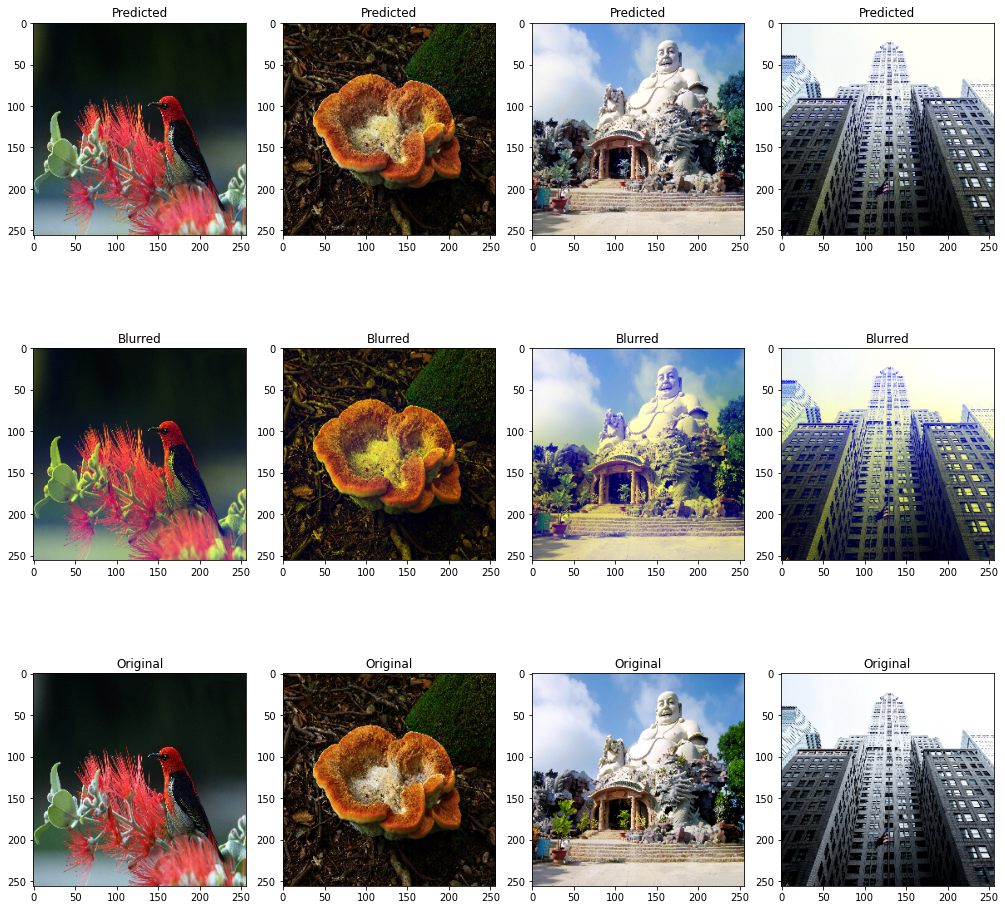

In [10]:
m = 0  # index of the image in the dataset
k = 4    # how many imgaes to show after image(m)
s = 14  # size of the image to show
fig, axes = plt.subplots(nrows=3, ncols=k, sharex=True, sharey=True, figsize = (s,s))

for i in range(k): 
    result = np.zeros((IMG_SIZE, IMG_SIZE, 3))
    r, g, b = cv2.split(XX[i+m])
    result[:,:,0] = r
    result[:,:,1] = g
    result[:,:,2] = np.abs(output[i+m])
    plt.subplot(3, k, i+1)
    plt.imshow(result)
    plt.title('Predicted')
    
    plt.subplot(3, k, i+1+k)
    plt.imshow(XX[i+m])
    plt.title('Blurred')
    
    org = np.zeros((IMG_SIZE, IMG_SIZE, 3))
    r, g, b = cv2.split(XX[i+m])
    org[:,:,0] = r
    org[:,:,1] = g
    org[:,:,2] = YY[i+m]
    plt.subplot(3, k, i+1+k+k)
    plt.imshow(org)
    plt.title('Original')

fig.tight_layout()
plt.show()

**Visual results (Blue channel only)**

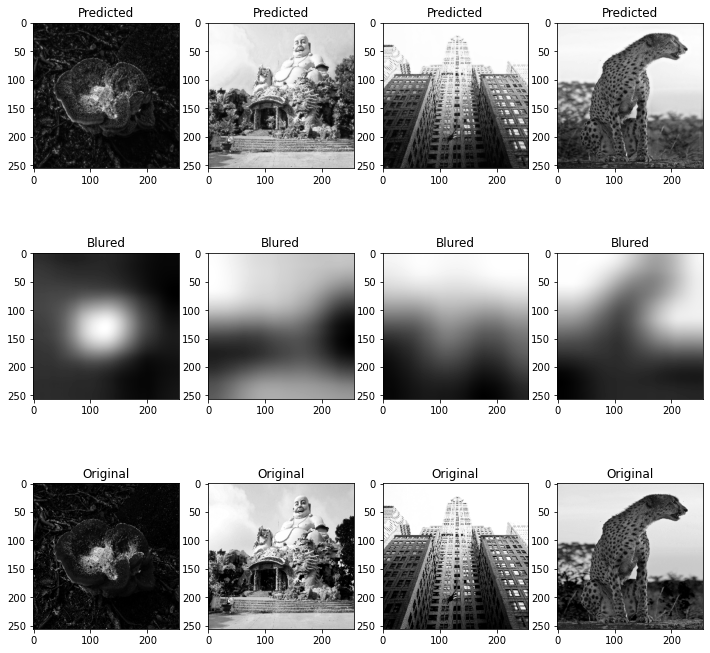

In [13]:
m = 1   # index of the image in the dataset
k = 4   # how many imgaes to show after image(m)
s = 12  # size of the image to show
fig, axes = plt.subplots(nrows=3, ncols=k, sharex=True, sharey=True, figsize = (s,s))

for i in range(k):  
    plt.subplot(3, k, i+1)
    plt.imshow(np.abs(output[i+m]))
    plt.title('Predicted')
    plt.gray()
    
    r, g, b = cv2.split(XX[i+m])
    plt.subplot(3, k, i+1+k)
    plt.imshow(b)
    plt.title('Blured')
    plt.gray()
    
    plt.subplot(3, k, i+1+k+k)
    plt.imshow(YY[i+m])
    plt.title('Original')
    plt.gray()


plt.show()

**The difference between the original blue predicted**

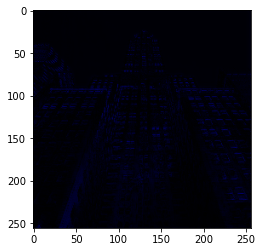

In [15]:
plt.imshow(np.abs(org-result))
plt.show()